In [1]:
# Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Note : 

**The result varies due to the random initialization of the clusters in the Kmeans. Therefore, the comments and notes quoted in the notebook might not hold on a rerun**

**The results mentioned in the ppt are consistent with the notebook, but the cluster numbers for Kmeans are different since it changes on different runs**

In [2]:
# Read the dataset into a pandas dataframe

country_df = pd.read_csv("Country-data.csv", sep=",", header=0)
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


The description of the columns 

* **country** - Name of the country

* **child_mort** - Death of children under 5 years of age per 1000 live births

* **exports** - Exports of goods and services per capita. Given as %age of the GDP per capita

* **health** - Total health spending per capita. Given as %age of GDP per capita

* **imports** - Imports of goods and services per capita. Given as %age of the GDP per capita

* **income** - Net income per person

* **Inflation** - The measurement of the annual growth rate of the Total GDP

* **life_expec** - The average number of years a new born child would live if the current mortality patterns are to remain the same

* **total_fer** - The number of children that would be born to each woman if the current age-fertility rates remain the same.

* **gdpp** - The GDP per capita. Calculated as the Total GDP divided by the total population.

In [3]:
# print the infor the dataframe
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


We see there are 167 entries with no null entries. There are 10 columns where 7 columns have floating point values, one column has country is object type and income and gdpp are integere type columns

In [4]:
# Check for missing values per column in terms of percentage
round(100*(country_df.isnull().sum())/len(country_df), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

No null values to be found in any of the column

#### Type check all the elements per column, whether they are consistent or not


In [5]:
# Whethere the each of the element for each of the column has consistent data type w.r.t the defined datatype for the column.

list_columns = list(country_df.columns)
list_n_datatype = [1 if (np.array_equal(country_df[f"{col}"], 
                   country_df[f"{col}"].astype(country_df[col].dtype))) else 0 
                   for col in country_df.columns]

# List stores [1, 0, ...] where 1 means the datatype matches for each of the element for the column 
# with defined datatype else 0

# Check if the sum of the list_n_datatype == len(list_n_datatype) -> all datatypes are consistent

if sum(list_n_datatype) == len(list_n_datatype):
    print('All datatypes are consistent with the values in the column')
else:
    print(f" The columns with mismatching datatypes per entries: {[list_columns[idx] for idx, flag in enumerate(list_n_datatype) if idx == 0]}")


All datatypes are consistent with the values in the column


**The dataframe overview information has been understood, the descriptive statistics printed, the Null/Nan values have been checked, the dtype values per entry in a column has been checked.**


### Exploratory Data Analysis 

#### Categorical Variable

In [6]:


# We observe there is only 1 categorical variable and rest of the variables are continuous.

# The categorical variable country is a nominal variable, which is used as a indexing variable
# Therefore we don't need to bar plot to check the frequency of the different classes in the variable.

print(f"The number of country in the dataset : {len(country_df.country)}")


The number of country in the dataset : 167


#### Continuous variables

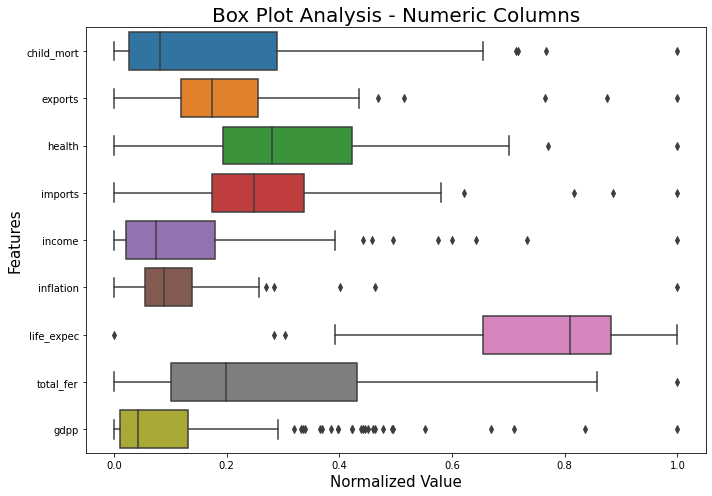

In [7]:
# Box plot for the numerical columns
# Normalize the numeric columns so that the values can be plotted on the same scale

list_columns.pop(list_columns.index('country'))
plt.figure(figsize=(10,7))
min_max_scaler = preprocessing.MinMaxScaler()
df_numer = country_df[list_columns]
x_scaled = min_max_scaler.fit_transform(df_numer)
df_normalized = pd.DataFrame(x_scaled)
df_normalized.columns = list_columns
sns.boxplot(y="variable", x="value", data=pd.melt(df_normalized), orient='h')
plt.xlabel('Normalized Value', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Box Plot Analysis - Numeric Columns', fontsize=20)
plt.tight_layout()
plt.show()

Observations from the above Box plot of the numeric columns

* The variable **inflation** has the least variance in the data points. The first quartile and 3rd quartile range values are magnitudnally small. It has has outliers on the right tail, which makes this variable prone to outlier effect which is something not admired in the case of clustering algoithms, since they work with th euclidean distances which are dependent on the magnitude of the values which are need to be used to compute it.

* The variables **gdpp** and **exports** are also **heavily affected by the outliers** on the right tail.

* **life_expec** has **outliers on the lower end**, but the variable has a significant spread of the values which are mostly on the higher end of normalized magnitude.

* All the variables have outliers. But these extremeties in different columns needs to be checked whether we need to drop them or not.

#### Outlier Analysis

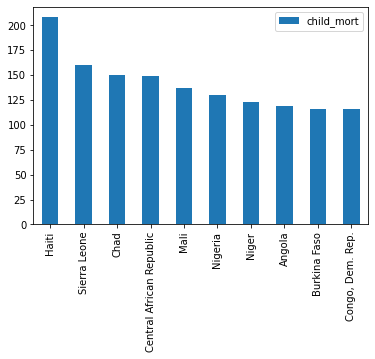

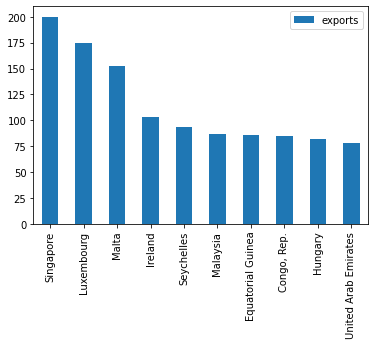

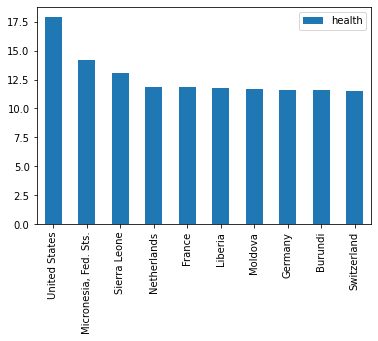

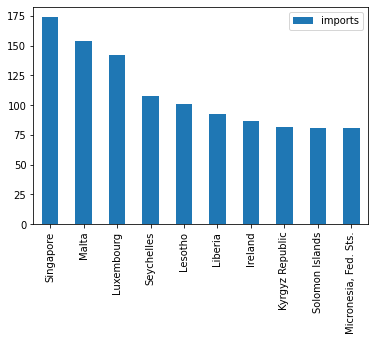

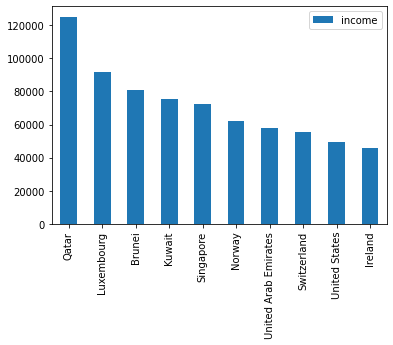

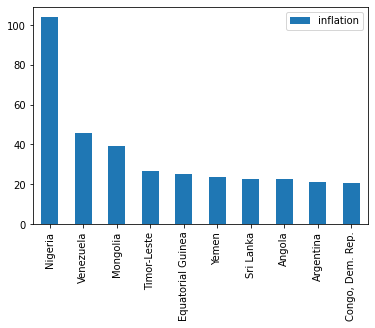

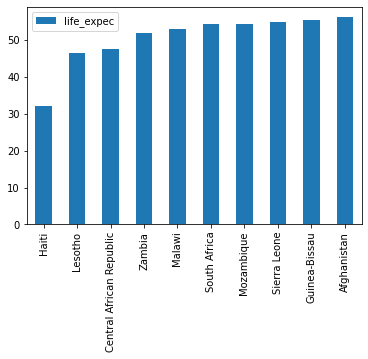

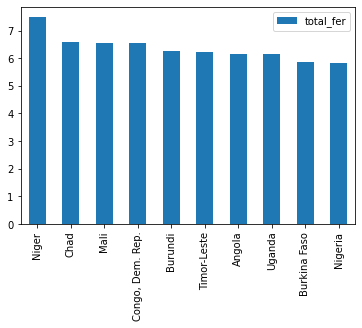

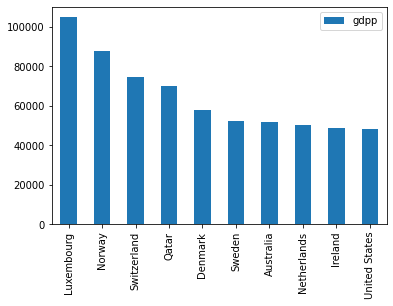

In [8]:
# Print the outlier values per column, top 10 entry descending orde for right tails columns and top 10 in ascening order
# for the left tails columns.
for col in list_columns:
    
    if col == 'life_expec':
        countries = list(country_df[['country', col]].sort_values(by=col).head(10)['country'])
        country_df[['country', col]].sort_values(by=col).head(10).plot(kind = 'bar')
        plt.xticks(range(len(countries)), countries)
    else:
        countries = list(country_df[['country', col]].sort_values(by=col, ascending=False).head(10)['country'])
        country_df[['country', col]].sort_values(by=col, ascending=False).head(10).plot(kind = 'bar')
        plt.xticks(range(len(countries)), countries)
    
    


We clearly see that the outliers are facts about the countries for e.g. Child mortality rate is High in Countries like Sierra Leone and Chad which are African Nations. It will be evidently be high due to poor health infrastructure. Thus, these outliers would have to incorporated in the dataset, which speaks for these adversities.

#### Bivariate Analysis

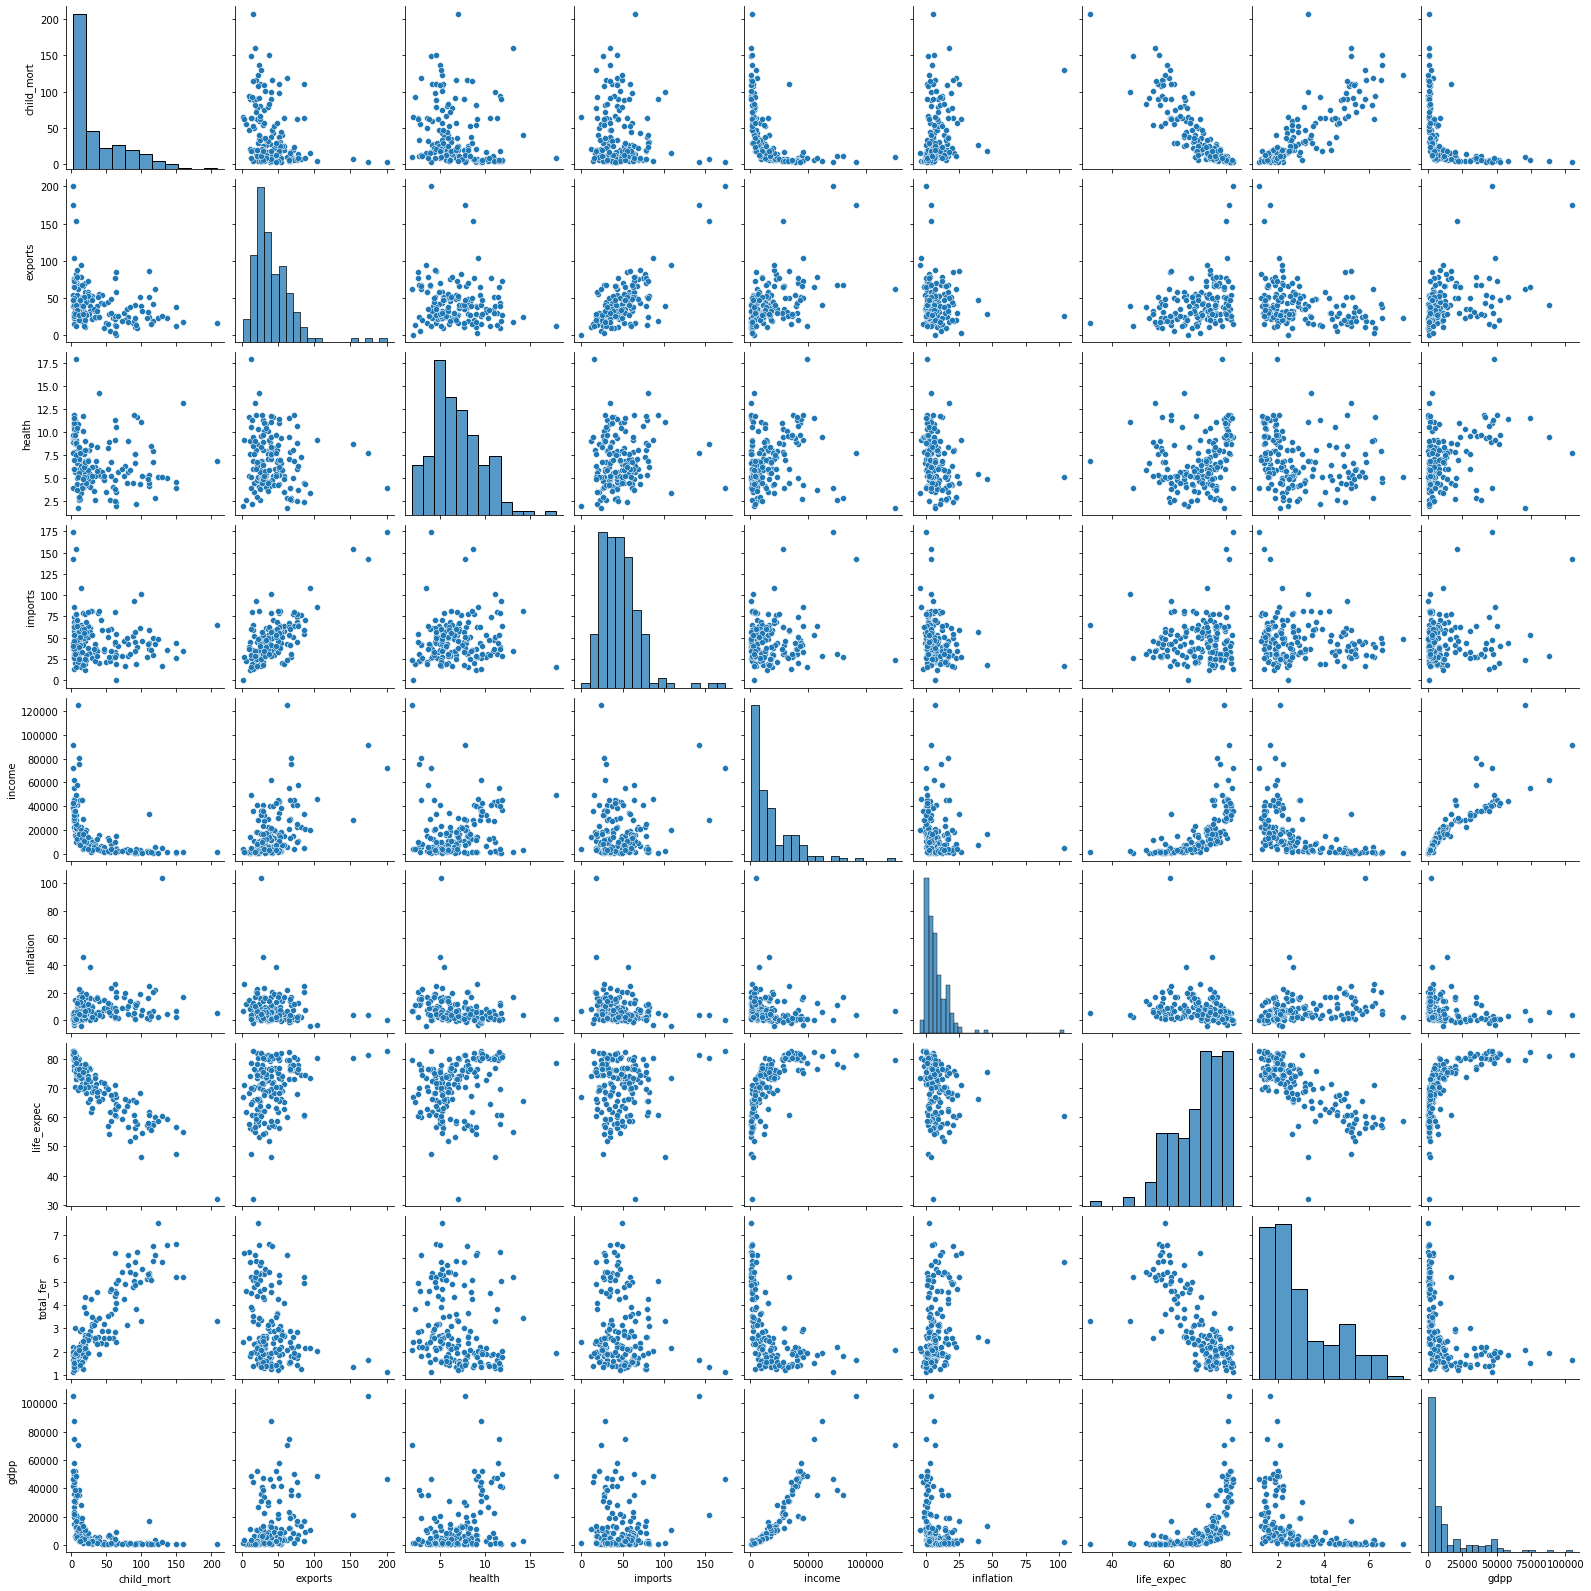

In [9]:
# Pairwise scatter plot for all the columns
sns.pairplot(country_df[list_columns])
plt.show()

**Bi-variate observations** 

* The total fertility has a high positive correlated with Child Mortality. That means countries with high fertility also have a high Child Mortality rate.

* The Child mortaility has a high negative correlation with life_expectancy, which makes sense too since infantry deaths also leads to lowering of the average life a person in the country.

* Exports have a strong positive correlation with the imports too.

* Health has some moderate positive correlation with the life_expectancy.

* Interestingly, imports have some positive correlation with health. That means healthier population is a exploratory buyer.

* Imports also positively correlate with the life expectancy of a nation.

* Income has a high positive correlation with exports, health, imports and gdpp.

* Life expectancy is high negatively correlated with total fertility.


### K-means Modelling


In [10]:
# Standardize all the columns first

scaler = preprocessing.StandardScaler()
df_standard = scaler.fit_transform(country_df[list_columns])
df_standard.shape

(167, 9)

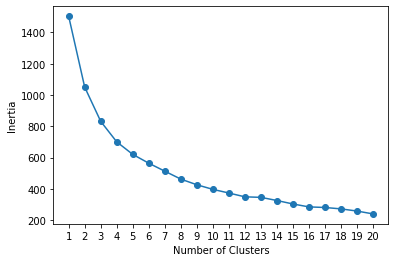

In [11]:
# Find the optimal number of clusters.
# elbow-curve/SSD
ssd = []
for num_clusters in range(1,21):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_standard)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot([x for x in range(1, 21)], ssd, marker = 'o')
plt.xticks([x for x in range(1, 21)] ,[x for x in range(1,21)])
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

For n_clusters=2, the silhouette score is 0.2873566892140671
For n_clusters=3, the silhouette score is 0.28329575683463126
For n_clusters=4, the silhouette score is 0.301375962376881
For n_clusters=5, the silhouette score is 0.21881220021245637
For n_clusters=6, the silhouette score is 0.22745133340502083
For n_clusters=7, the silhouette score is 0.24905003461730515
For n_clusters=8, the silhouette score is 0.244300996617202
For n_clusters=9, the silhouette score is 0.20871848961820422
For n_clusters=10, the silhouette score is 0.21618984289755527
For n_clusters=11, the silhouette score is 0.2130628428756193
For n_clusters=12, the silhouette score is 0.212413420693823
For n_clusters=13, the silhouette score is 0.1904226386468001
For n_clusters=14, the silhouette score is 0.19867586053547084
For n_clusters=15, the silhouette score is 0.21848838577641227
For n_clusters=16, the silhouette score is 0.22057330468043218
For n_clusters=17, the silhouette score is 0.20043707085169218
For n_clu

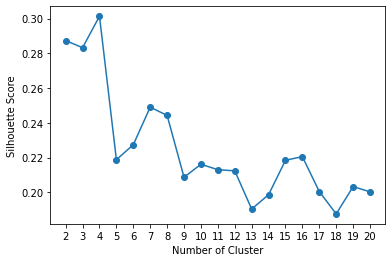

In [12]:
# Silhouette Analysis

sil_scores = []

for num_clusters in range(2,21):
    
    # Intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_standard)
    
    cluster_labels = kmeans.labels_
    
    # Silhouette score
    silhouette_avg = silhouette_score(df_standard, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    sil_scores.append(silhouette_avg)

plt.plot([x for x in range(2, 21)], sil_scores, marker='o')
plt.xticks([x for x in range(2, 21)] ,[x for x in range(2,21)])
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Both the Elbow method and the Sihouette method provides evidence to the fact that 4 should be the number of clusters that we should be using as the optimal number.


#### Model Kmeans with clusters = 4

In [46]:
# final model with k=5
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df_standard)

KMeans(max_iter=50, n_clusters=4)

In [47]:
# Add cluster id as a column to the country_df

country_df['cluster_id'] = kmeans.labels_
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,hc_labels
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,3,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,3,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3,1


### Bivariate plots of child mortality, gdpp and income for the 4 clusters.

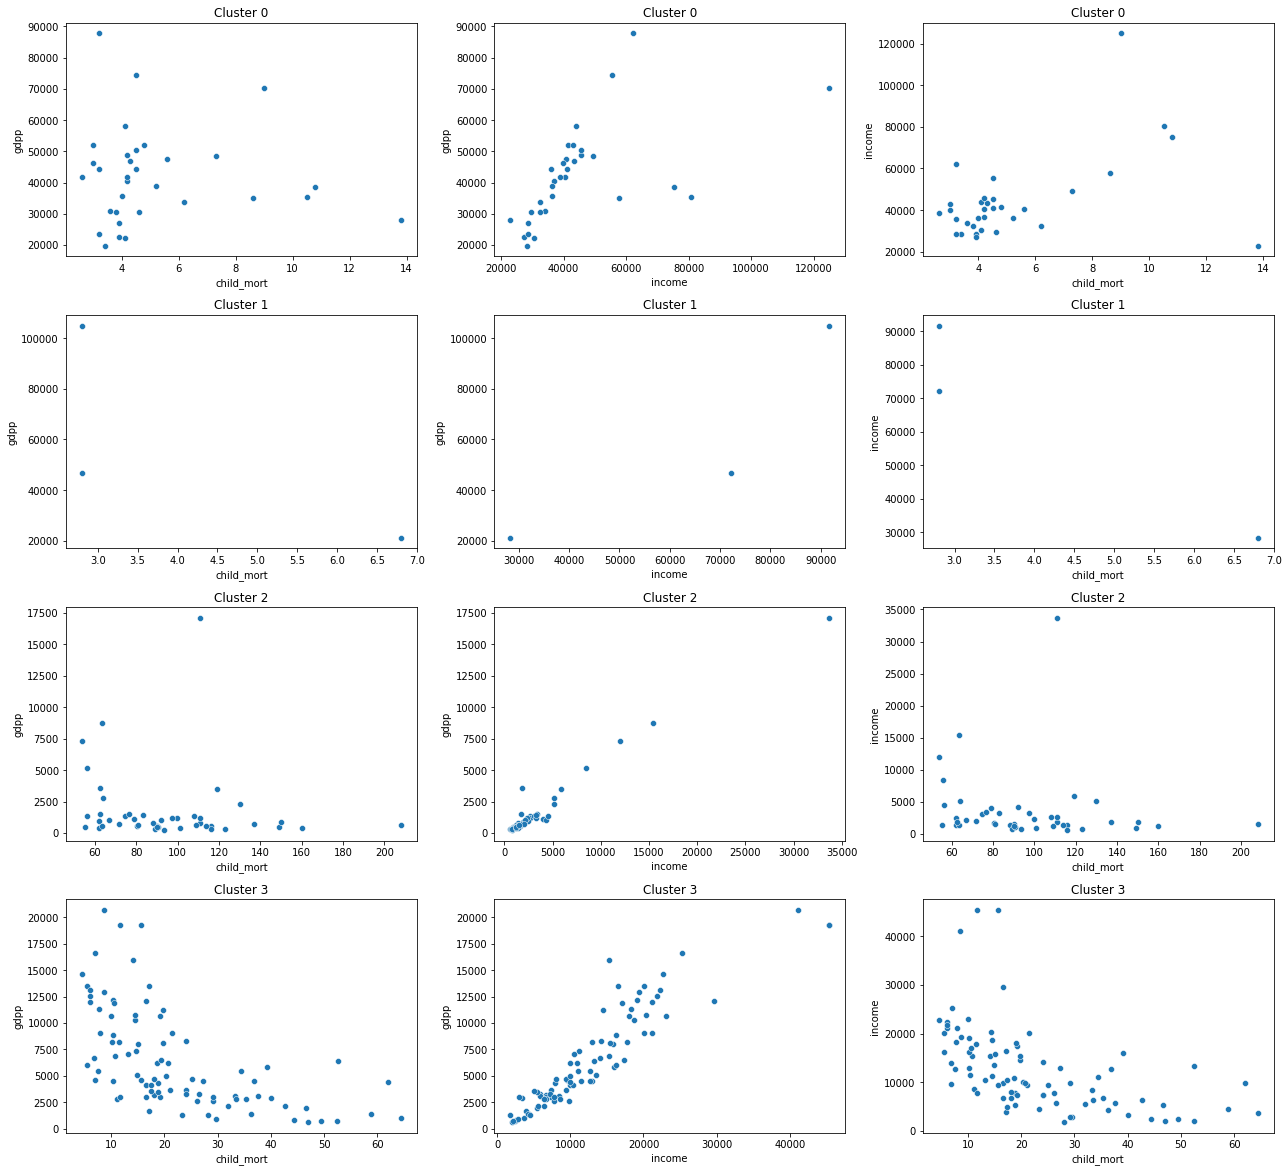

In [48]:
# Bivariate analysis for child mortality, gdpp and income for the 6 clusters.

# Plot cluster 0 for the three columns gdpp child mortality and income.
plt.figure(figsize = (18,20))

# Cluster 0
plt.subplot(5,3,1)
sns.scatterplot(x='child_mort', y='gdpp', data=country_df[country_df['cluster_id'] == 0])
plt.title('Cluster 0')
plt.subplot(5,3,2)
sns.scatterplot(x='income', y='gdpp', data=country_df[country_df['cluster_id'] == 0])
plt.title('Cluster 0')
plt.subplot(5,3,3)
sns.scatterplot(x='child_mort', y='income', data=country_df[country_df['cluster_id'] == 0])
plt.title('Cluster 0')

#Cluster 1
plt.subplot(5,3,4)
sns.scatterplot(x='child_mort', y='gdpp', data=country_df[country_df['cluster_id'] == 1])
plt.title('Cluster 1')
plt.subplot(5,3,5)
sns.scatterplot(x='income', y='gdpp', data=country_df[country_df['cluster_id'] == 1])
plt.title('Cluster 1')
plt.subplot(5,3,6)
sns.scatterplot(x='child_mort', y='income', data=country_df[country_df['cluster_id'] == 1])
plt.title('Cluster 1')
# Cluster 2
plt.subplot(5,3,7)
sns.scatterplot(x='child_mort', y='gdpp', data=country_df[country_df['cluster_id'] == 2])
plt.title('Cluster 2')
plt.subplot(5,3,8)
sns.scatterplot(x='income', y='gdpp', data=country_df[country_df['cluster_id'] == 2])
plt.title('Cluster 2')
plt.subplot(5,3,9)
sns.scatterplot(x='child_mort', y='income', data=country_df[country_df['cluster_id'] == 2])
plt.title('Cluster 2')
# Cluster 3
plt.subplot(5,3,10)
sns.scatterplot(x='child_mort', y='gdpp', data=country_df[country_df['cluster_id'] == 3])
plt.title('Cluster 3')
plt.subplot(5,3,11)
sns.scatterplot(x='income', y='gdpp', data=country_df[country_df['cluster_id'] == 3])
plt.title('Cluster 3')
plt.subplot(5,3,12)
sns.scatterplot(x='child_mort', y='income', data=country_df[country_df['cluster_id'] == 3])
plt.title('Cluster 3')
plt.tight_layout()
plt.show()

We observe for the cluster 2, the gdpp is lower and the child mortality is spread across with data points of higher child mortality too. We also see cluster has a concentrate of data points with low gdpp and low income, both pointing to the adverse conditions. This cluster's scatter projections indicates this cluster fits our aiding criterion.

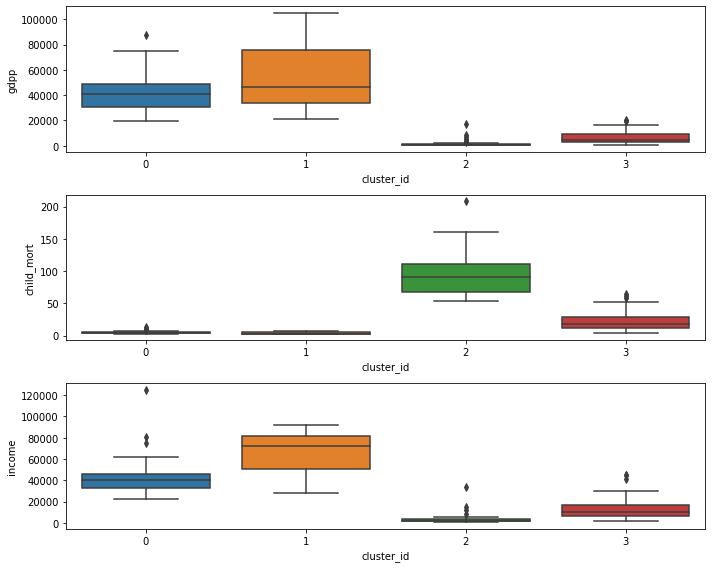

In [49]:
# Plot cluster for the three columns gdpp child mortality and income.
plt.figure(figsize = (10,8))
plt.subplot(3,1,1)
sns.boxplot(x='cluster_id', y='gdpp', data=country_df)
plt.subplot(3,1,2)
sns.boxplot(x='cluster_id', y='child_mort', data=country_df)
plt.subplot(3,1,3)
sns.boxplot(x='cluster_id', y='income', data=country_df)
plt.tight_layout()
plt.show()

We clearly see that cluster 2 has a low gdpp, high child mortality and low income. It becomes our ideal to whom we need to provide the aid.

In [50]:
# Print the name of the countries falling in the cluster
km_countries = country_df[country_df['cluster_id'] == 2]['country']
print(list(country_df[country_df['cluster_id'] == 2]['country']))

['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


### Hierarchical Clustering 

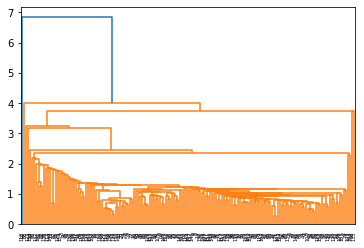

In [51]:
# Let's first try single linkage

mergings = linkage(df_standard, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

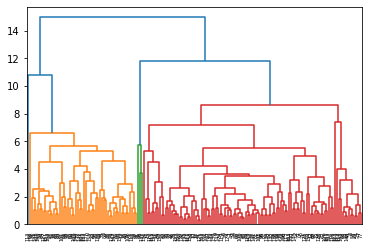

In [52]:
# Complete Linkage

mergings = linkage(df_standard, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [53]:
# Let's try to cut the tree at 6 clusters as what we found previously in the case of Kmeans.
# Here too we see that at level = 6, 
cluster_labels = cut_tree(mergings, n_clusters=6).reshape(-1, )

In [54]:
country_df['hc_labels'] = cluster_labels
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,hc_labels
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,3,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,3,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3,1


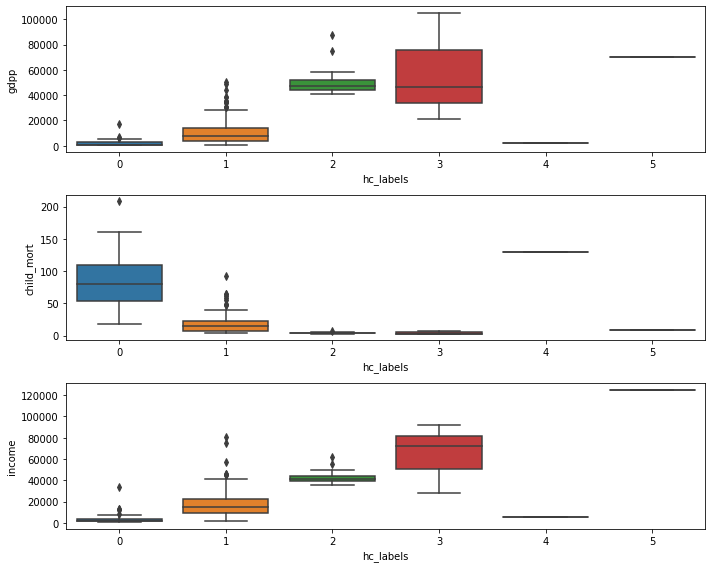

In [55]:
# Plot cluster-wise for the three columns gdpp child mortality and income.
plt.figure(figsize = (10,8))
plt.subplot(3,1,1)
sns.boxplot(x='hc_labels', y='gdpp', data=country_df)
plt.subplot(3,1,2)
sns.boxplot(x='hc_labels', y='child_mort', data=country_df)
plt.subplot(3,1,3)
sns.boxplot(x='hc_labels', y='income', data=country_df)
plt.tight_layout()
plt.show()

In [56]:
# Here we see the cluster 0 has low gdpp, income and high child mortality rate.

# Print the name of the countries falling in the cluster 0
hc_countries = country_df[country_df['hc_labels'] == 0]['country']
print(list(country_df[country_df['hc_labels'] == 0]['country']))

['Afghanistan', 'Angola', 'Benin', 'Bhutan', 'Botswana', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Fiji', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Micronesia, Fed. Sts.', 'Mozambique', 'Namibia', 'Niger', 'Rwanda', 'Samoa', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'South Africa', 'Sudan', 'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Tonga', 'Uganda', 'Vanuatu', 'Yemen', 'Zambia']


In [57]:
# Let's try to get the intersection of th countries we got in the case of Kmeans and in the case of hierarchical clustering
print(f'Total number of potential countries segmented by Kmeans  : {len(km_countries)}')
print(f'Total number of potential countries segmented by Hierarchical clustering  : {len(hc_countries)}')
filter_countries = set(km_countries).intersection(set(hc_countries))
print(f'Total number of countries in the intersection of the potential segments of Kmean and Hierarchical clustering : {len(filter_countries)}')
print(filter_countries)

Total number of potential countries segmented by Kmeans  : 45
Total number of potential countries segmented by Hierarchical clustering  : 54
Total number of countries in the intersection of the potential segments of Kmean and Hierarchical clustering : 41
{'Namibia', 'Chad', 'Mauritania', 'Togo', 'Burundi', 'Guinea', 'Uganda', 'Sierra Leone', 'Comoros', 'Niger', 'Lesotho', 'Mali', 'Afghanistan', 'Congo, Dem. Rep.', 'Burkina Faso', 'Congo, Rep.', 'Senegal', "Cote d'Ivoire", 'Liberia', 'Madagascar', 'Yemen', 'Ghana', 'Timor-Leste', 'Benin', 'Angola', 'Kenya', 'Kiribati', 'Cameroon', 'Gambia', 'South Africa', 'Zambia', 'Mozambique', 'Haiti', 'Equatorial Guinea', 'Sudan', 'Rwanda', 'Central African Republic', 'Tanzania', 'Malawi', 'Guinea-Bissau', 'Lao'}


We see that total of 46 potential countries come out as the candidates from which we need to choose the top 5 countries for aid. Let's analyse the columns gdpp, income and childmortality for these 41 countries to filter out atleast 5 countries.

### Selecting Countries for the Financial Aid

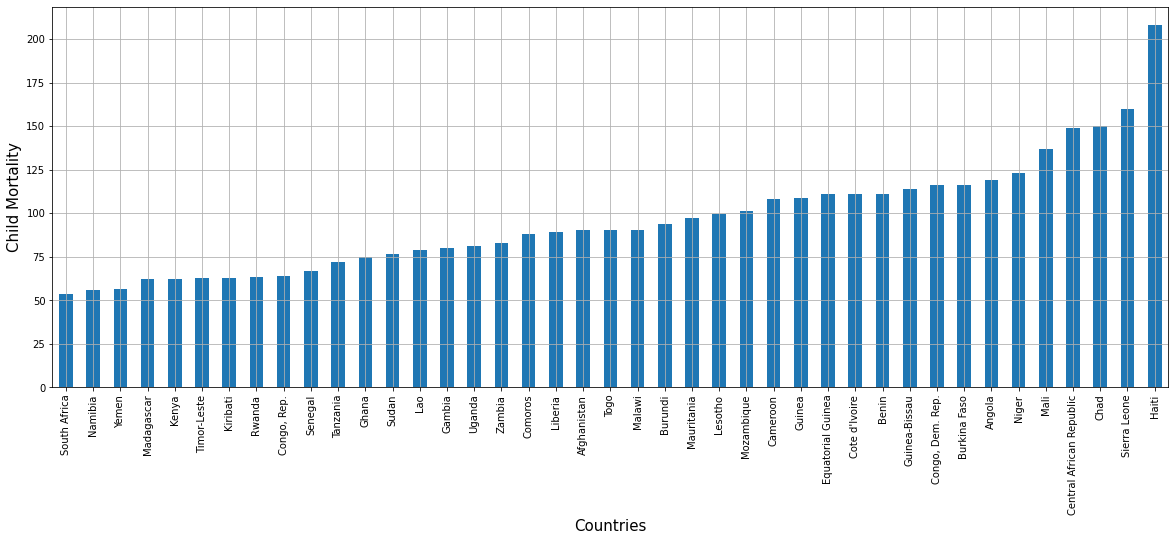

In [58]:
# Plot Child mortality for the candidate countries
plt.figure(figsize=(20,7))
country_df[country_df['country'].isin(list(filter_countries))].sort_values(by='child_mort')['child_mort'].plot(kind='bar')
indexs_child_mort = list(country_df[country_df['country'].isin(list(filter_countries))].sort_values(by='child_mort')['country'].values)
plt.xticks(range(len(indexs_child_mort)), indexs_child_mort)
plt.xlabel('Countries', size=15)
plt.ylabel('Child Mortality', size=15)
plt.grid()
plt.show()

Top 10 countries with highest child mortality : 
1. Haiti
2. Sierra Leone
3. Chad
4. Central African Republic
5. Mali
6. Niger
7. Angola
8. Burkina Faso
9. Congo Dem Rep
10. Guinea-Bissau


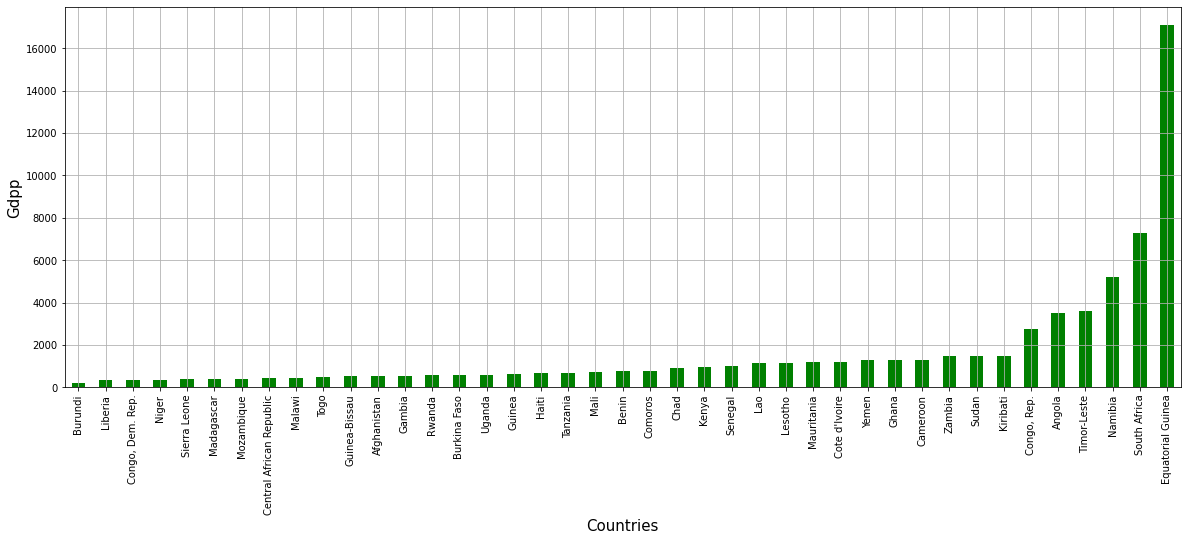

In [59]:
# Plot gdpp for the candidate countries
plt.figure(figsize=(20,7))
country_df[country_df['country'].isin(list(filter_countries))].sort_values(by='gdpp')['gdpp'].plot(kind='bar', color='green')
indexs_gdpp = list(country_df[country_df['country'].isin(list(filter_countries))].sort_values(by='gdpp')['country'].values)
plt.xticks(range(len(indexs_gdpp)), indexs_gdpp)
plt.xlabel('Countries', size=15)
plt.ylabel('Gdpp', size=15)
plt.grid()
plt.show()

Top 10 countries with lowest Gdpp

1. Burundi
2. Liberia
3. Congo Dem Rep
4. Niger
5. Sierra Leone
6. Madagascar
7. Mozambique
8. Central African Republic
9. Malawi
10. Togo


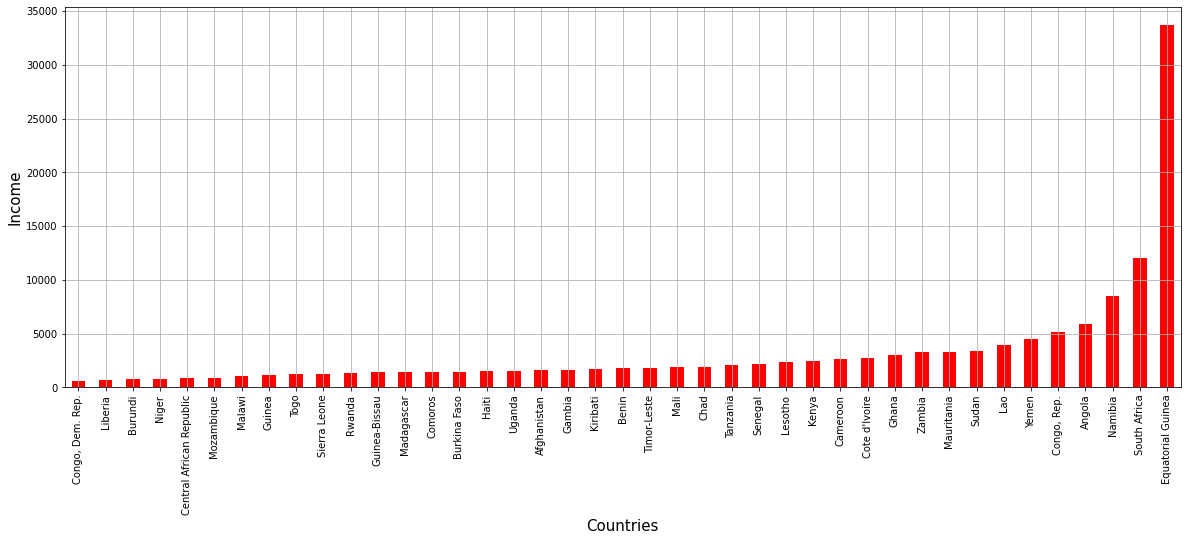

In [60]:
# Plot Income for the candidate countries
plt.figure(figsize=(20,7))
country_df[country_df['country'].isin(list(filter_countries))].sort_values(by='income')['income'].plot(kind='bar', color='r')
indexs_income = list(country_df[country_df['country'].isin(list(filter_countries))].sort_values(by='income')['country'].values)
plt.xticks(range(len(indexs_income)), indexs_income)
plt.xlabel('Countries', size=15)
plt.ylabel('Income', size=15)
plt.grid()
plt.show()

Top 10 countries with lowest income

1. Congo Demo Republic
2. Liberia
3. Burundi
4. Niger
5. Central African Republic
6. Mozambique
7. Malawii
8. Guinea
9. Togo
10. Sierra Leone



In [61]:
# Intersection of the top 15 countries among child mortality, gdpp and income. 

aid_countries = set(indexs_child_mort[-15:-1]).intersection(set(indexs_gdpp[0:15])).intersection(set(indexs_income[0:15]))
aid_countries

{'Burkina Faso',
 'Central African Republic',
 'Congo, Dem. Rep.',
 'Guinea-Bissau',
 'Niger',
 'Sierra Leone'}

### Among the top 15 countries with highest Child mortality rate, Lowest gdpp and Lowest income, we see that there are 6 countries in the intersection of these attributes and since we have to choose atleast 5, following would be the countries that would be nominated for aid : 


### 1. **Burkina Faso**
### 2. **Central African Republic**
### 3. **Congo Dem. Rep**
### 4. **Guinea-Bissau**
### 5. **Niger**
### 6. **Sierra Leone**